<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Survival-Analysis-&amp;-NFL-Injuries" data-toc-modified-id="Survival-Analysis-&amp;-NFL-Injuries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Survival Analysis &amp; NFL Injuries</a></span></li><li><span><a href="#Synthetic-vs-Natural-Data-Split" data-toc-modified-id="Synthetic-vs-Natural-Data-Split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Synthetic vs Natural Data Split</a></span></li><li><span><a href="#Ideas" data-toc-modified-id="Ideas-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ideas</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#BodyPart" data-toc-modified-id="BodyPart-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>BodyPart</a></span></li></ul></li><li><span><a href="#Roster-Position" data-toc-modified-id="Roster-Position-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Roster Position</a></span></li><li><span><a href="#Hazard-Rate-Model" data-toc-modified-id="Hazard-Rate-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Hazard Rate Model</a></span><ul class="toc-item"><li><span><a href="#Kaplan-Meier-Estimate" data-toc-modified-id="Kaplan-Meier-Estimate-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Kaplan-Meier Estimate</a></span></li></ul></li><li><span><a href="#Cox-Proportional-Hazard-Model" data-toc-modified-id="Cox-Proportional-Hazard-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Cox Proportional Hazard Model</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></div>

# Survival Analysis & NFL Injuries

The goal was to understand player injuries based on specific variables related to plays and game conditions. I tried some more traditional survival analysis models as well as some basic ML models. Enjoy!

In [4]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as patches
import pandas_profiling
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from time import time
# Load the data files
playlist = pd.read_csv('./input/PlayList.csv')
injuries = pd.read_csv('./input/InjuryRecord.csv')
tracking = pd.read_csv('./input/PlayerTrackData.csv', nrows=int(1e6)) # load only a fraction of the data

In [5]:
playlist.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [6]:
injuries.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


# Synthetic vs Natural Data Split

In [7]:
inj_natural = injuries[injuries.Surface == 'Natural']
inj_turf = injuries[injuries.Surface == 'Synthetic']

In [8]:
inj_natural.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
5,41145,41145-2,41145-2-60,Knee,Natural,1,0,0,0
7,44860,44860-5,44860-5-52,Knee,Natural,1,1,0,0
11,36621,36621-13,36621-13-58,Foot,Natural,1,1,1,1


In [9]:
inj_turf.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1
6,46014,46014-10,46014-10-22,Ankle,Synthetic,1,1,1,1
8,44806,44806-7,44806-7-61,Knee,Synthetic,1,0,0,0


# Ideas

Visualize the field

Heatmaps of different types of injuries

Heatmaps with player position on days missed on synthetic vs real turf

Trends when connecting Player injuries to the attributes of the play

Ultimately have to connect it to a surface factor 

Build a logistic model that predicts probability of injury based on surface type.

How early in the game do they get injured based on the surface. 

Number of plays it takes for an injury based on position. 

Number of days missed based on injury

# Data Cleaning


In [10]:
inj_nat_play = pd.merge(inj_natural,
                 playlist,
                 on=['PlayerKey', 'GameID', 'PlayKey'],
                       how='left')
inj_tur_play = pd.merge(inj_turf,
                 playlist,
                 on=['PlayerKey', 'GameID', 'PlayKey'],
                       how ='left')

inj_play = pd.merge(injuries,
                 playlist,
                 on=['PlayerKey', 'GameID', 'PlayKey'],
                       how ='left')

inj_play_enc = pd.concat([inj_play,pd.get_dummies(inj_play['BodyPart'], prefix='part'), pd.get_dummies(inj_play['RosterPosition'], prefix='pos')],axis=1)

inj_play.head()


#put NAN play key into separate file then join with attributes


,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,Linebacker,29.0,4.0,Indoors,Synthetic,84.0,Cloudy,Punt,32.0,OLB,LB
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,Linebacker,50.0,7.0,Open,Natural,76.0,Partly Cloudy,Punt,26.0,OLB,LB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1.0,1.0,Outdoor,Synthetic,63.0,Clear and warm,Pass,70.0,SS,DB
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,Linebacker,15.0,3.0,Outdoor,Natural,80.0,Cloudy,Punt,30.0,LB,LB
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,Wide Receiver,32.0,5.0,Retractable Roof,Synthetic,89.0,Partly Cloudy,Kickoff,69.0,WR,WR


In [11]:
injuries['DM_M1'].value_counts()

1    105
Name: DM_M1, dtype: int64

In [12]:
injuries['DM_M7'].value_counts()

1    76
0    29
Name: DM_M7, dtype: int64

In [13]:
injuries['DM_M28'].value_counts()

0    68
1    37
Name: DM_M28, dtype: int64

In [14]:
injuries['DM_M42'].value_counts()

0    76
1    29
Name: DM_M42, dtype: int64

In [15]:
#Lots of values that need to be cleaned
playlist['StadiumType'].value_counts()

Outdoor                   145032
Outdoors                   32956
Indoors                    22805
Dome                        9376
Retractable Roof            8914
Indoor                      6892
Open                        4124
Domed, closed               3076
Retr. Roof - Closed         2235
Retr. Roof-Closed           2015
Domed, open                 1779
Dome, closed                1059
Closed Dome                 1011
Domed                        985
Oudoor                       914
Domed, Open                  807
Ourdoor                      778
Outdoor Retr Roof-Open       601
Outddors                     595
Indoor, Roof Closed          547
Retr. Roof-Open              486
Retr. Roof - Open            486
Indoor, Open Roof            479
Bowl                         465
Retr. Roof Closed            414
Heinz Field                  389
Outdor                       356
Outside                      341
Cloudy                       178
Name: StadiumType, dtype: int64

In [16]:
playlist['Weather'].value_counts()

Cloudy                                                                              60705
Sunny                                                                               51728
Partly Cloudy                                                                       28463
Clear                                                                               25923
Mostly Cloudy                                                                       11176
                                                                                    ...  
30% Chance of Rain                                                                    354
Partly Clouidy                                                                        302
Coudy                                                                                 278
Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.      246
Party Cloudy                                                                          230
Name: Weat

In [17]:
m_inju_play=pd.merge(playlist,injuries,on='PlayKey',how='left')
m_inju_play['Injury'] = m_inju_play['BodyPart'].apply(lambda x: 1 if x in ['Knee','Foot','Ankle']  else 0)

m_inju_play_agg=m_inju_play[['StadiumType','FieldType','Weather','Injury', 'PlayType', 'Position', 'PlayerDay', 'Temperature']]
#Change weather to 1 and 0
m_inju_play_agg['Weather']=m_inju_play_agg.Weather.isin(['rain','Rain','Snow','snow'])
m_inju_play_agg['Weather'] = m_inju_play_agg['Weather'].apply(lambda x: 1 if x== True  else 0)

m_inju_play_agg['StadiumType']=m_inju_play_agg.StadiumType.isin(['Outdoor','Oudoor','Open','Ourdoor','Out','open'])
m_inju_play_agg['StadiumType'] = m_inju_play_agg['StadiumType'].apply(lambda x: 1 if x== True  else 0)

m_inju_play_agg['FieldType']=m_inju_play_agg.FieldType.isin(['Natural'])
m_inju_play_agg['FieldType'] = m_inju_play_agg['FieldType'].apply(lambda x: 1 if x== True  else 0)

m_inju_play_agg.PlayType = pd.Categorical(m_inju_play_agg.PlayType)
m_inju_play_agg['PlayType_c'] = m_inju_play_agg.PlayType.cat.codes

m_inju_play_agg.Position = pd.Categorical(m_inju_play_agg.Position)
m_inju_play_agg['Position_c'] = m_inju_play_agg.Position.cat.codes

#Now we are going to multiplicate the StadiumType Variable with the Weather because the weather doesnt matter if the match is played on a closed stadium

m_inju_play_agg['Multiplication']=m_inju_play_agg['StadiumType']*m_inju_play_agg['Weather']

In [18]:
m_inju_play_agg.head()

,StadiumType,FieldType,Weather,Injury,PlayType,Position,PlayerDay,Temperature,PlayType_c,Position_c,Multiplication
0,1,0,0,0,Pass,QB,1,63,6,16,0
1,1,0,0,0,Pass,QB,1,63,6,16,0
2,1,0,0,0,Rush,QB,1,63,10,16,0
3,1,0,0,0,Rush,QB,1,63,10,16,0
4,1,0,0,0,Pass,QB,1,63,6,16,0


# EDA

## BodyPart

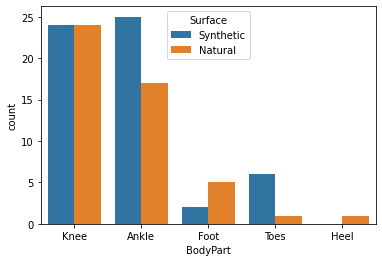

In [19]:
sns.countplot(data=inj_play, x='BodyPart', hue= 'Surface')

# Roster Position

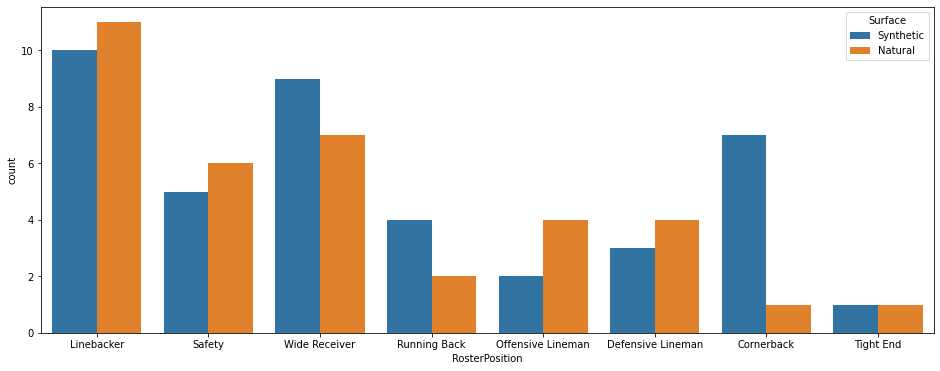

In [20]:
plt.figure(figsize=(16, 6))
sns.countplot(data=inj_play, x='RosterPosition', hue= 'Surface')

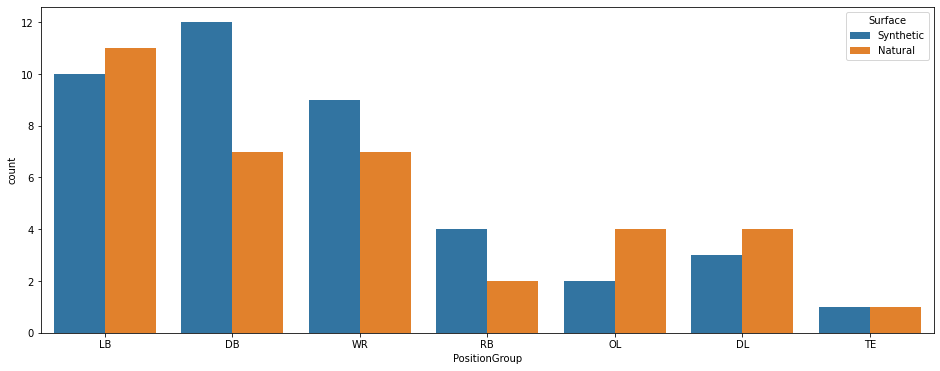

In [21]:
plt.figure(figsize=(16, 6))
sns.countplot(data=inj_play, x='PositionGroup', hue= 'Surface')

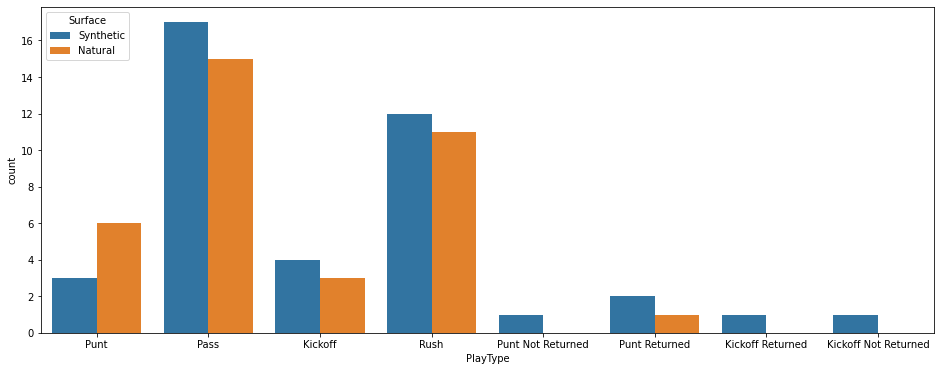

In [22]:
plt.figure(figsize=(16, 6))
sns.countplot(data=inj_play, x='PlayType', hue= 'Surface')

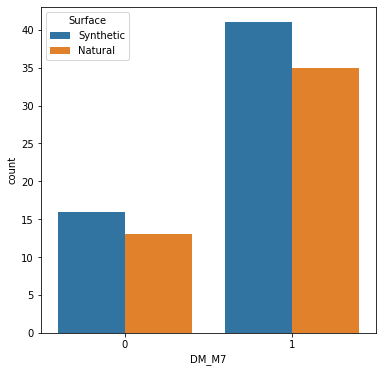

In [23]:
plt.figure(figsize=(6, 6))
sns.countplot(data=inj_play, x='DM_M7', hue= 'Surface')

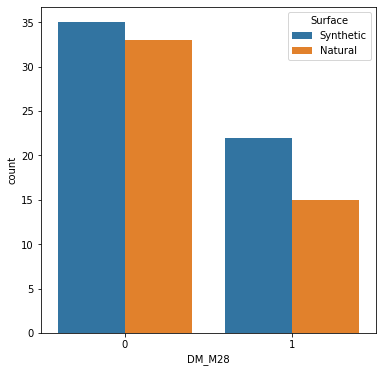

In [24]:
plt.figure(figsize=(6, 6))
sns.countplot(data=inj_play, x='DM_M28', hue= 'Surface')

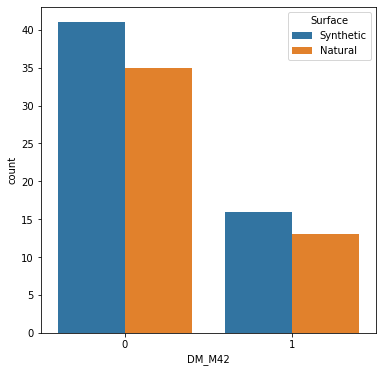

In [25]:
plt.figure(figsize=(6, 6))
sns.countplot(data=inj_play, x='DM_M42', hue= 'Surface')

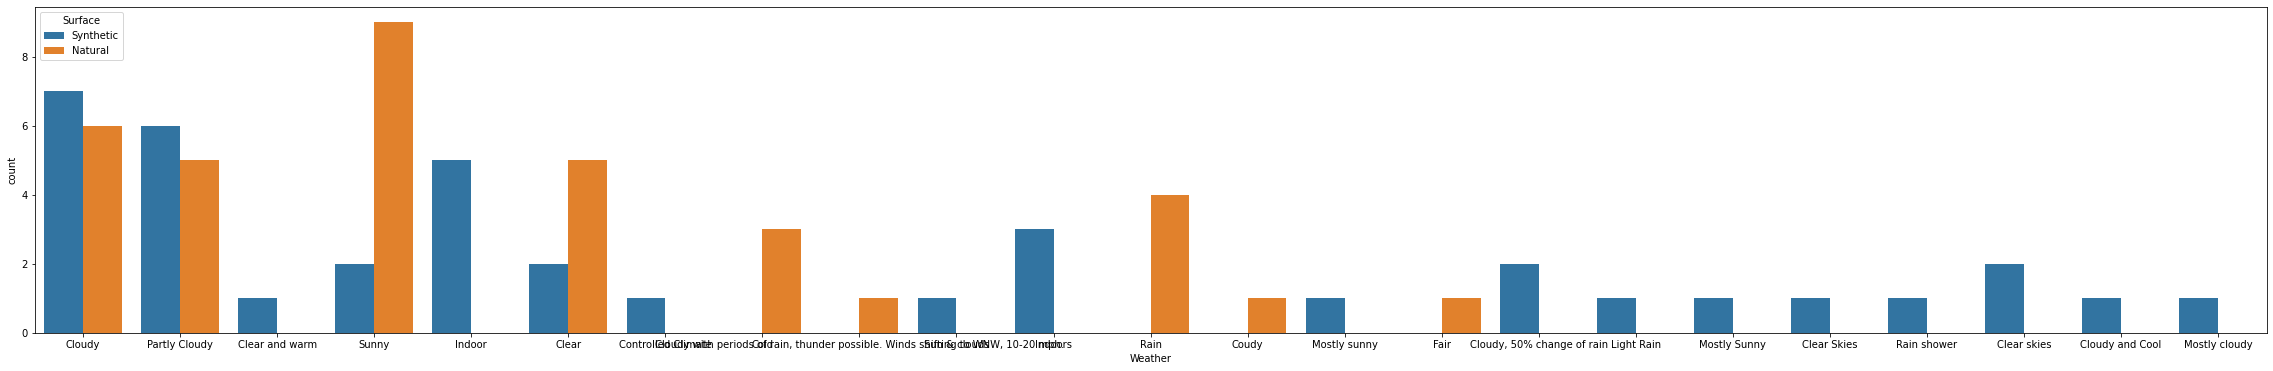

In [26]:
plt.figure(figsize=(40, 6))
sns.countplot(data=inj_play, x='Weather', hue= 'Surface')

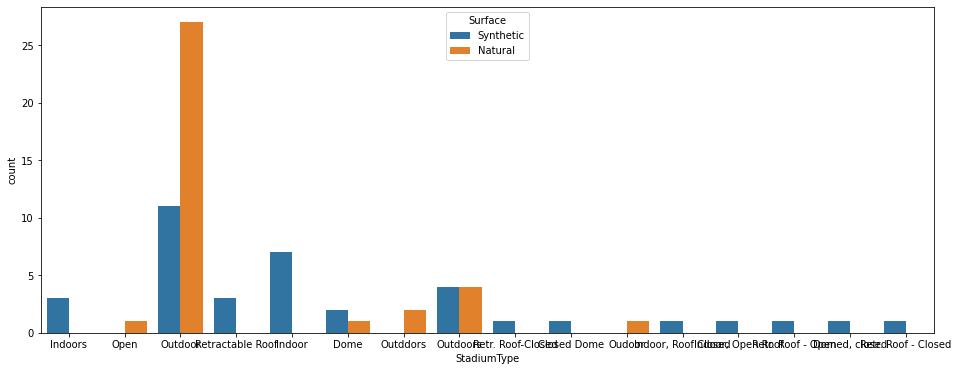

In [27]:
plt.figure(figsize=(16, 6))
sns.countplot(data=inj_play, x='StadiumType', hue= 'Surface')

Are there certain stadiums where they are occuring more than others?

What body parts are being injured by position? And by surface?

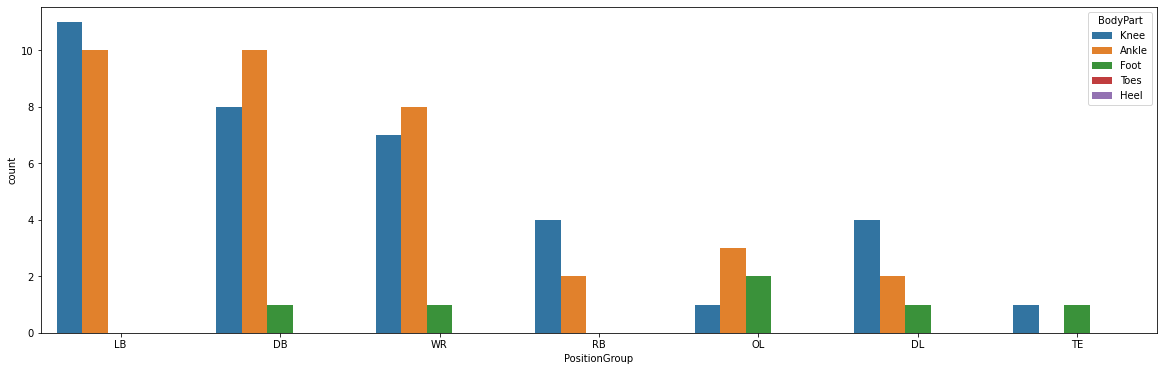

In [28]:
plt.figure(figsize=(20, 6))
sns.countplot(data=inj_play, x='PositionGroup', hue= 'BodyPart')

In [29]:
inj_play[inj_play['BodyPart'] == 'Toes']

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
49,45950,45950-6,NaN,Toes,Synthetic,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,38253,38253-10,NaN,Toes,Synthetic,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,38214,38214-12,NaN,Toes,Synthetic,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,47196,47196-7,NaN,Toes,Synthetic,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,45975,45975-23,NaN,Toes,Natural,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,47273,47273-10,NaN,Toes,Synthetic,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,40405,40405-29,NaN,Toes,Synthetic,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
injuries[injuries['BodyPart'] == 'Toes']

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
49,45950,45950-6,NaN,Toes,Synthetic,1,1,0,0
51,38253,38253-10,NaN,Toes,Synthetic,1,1,1,0
52,38214,38214-12,NaN,Toes,Synthetic,1,0,0,0
96,47196,47196-7,NaN,Toes,Synthetic,1,1,0,0
97,45975,45975-23,NaN,Toes,Natural,1,1,0,0
98,47273,47273-10,NaN,Toes,Synthetic,1,0,0,0
99,40405,40405-29,NaN,Toes,Synthetic,1,1,0,0


Changes in movement pattern across the surface. 

Number of injuries across days and player game. 

Model the time until injury and see if this changes across field types, use a hazard rate model and see if the rate changes. 

# Hazard Rate Model

For further details on the concept and definitions of Hazard Rate Models refer to this blog post.

https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e


## Kaplan-Meier Estimate

In [31]:
!pip install lifelines

  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4039 sha256=4141b118e7d456e932de43726b67d0aea68e2db0de78a88d81187f712517e63c
  Stored in directory: c:\users\prajwal\appdata\local\pip\cache\wheels\16\a2\b6\582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.0
    Uninstalling typing-extensions-3.10.0.0:
      Successfully uninstalled typing-extensions-3.10.0.0


ERROR: formulaic 0.4.0 has requirement scipy>=1.6, but you'll have scipy 1.5.0 which is incompatible.


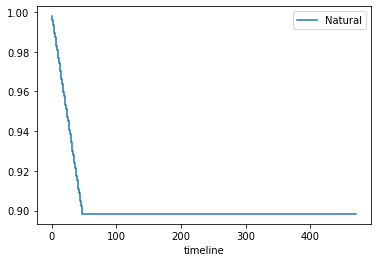

In [32]:
from lifelines import KaplanMeierFitter

##Natural Turf
## Example Data 
durations = list(range(int(max(inj_nat_play['PlayerDay'].dropna()))+1))
event_observed = [1 if dur in inj_nat_play['PlayerDay'] else 0 for dur in durations]

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Natural')

## Create an estimate
a1 = kmf.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

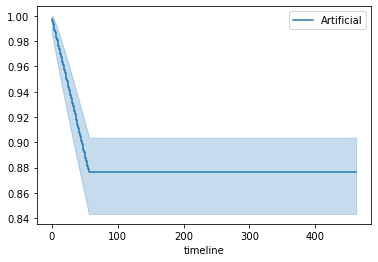

In [33]:
##Artificial Turf
## Example Data 
durations = list(range(int(max(inj_tur_play['PlayerDay'].dropna()))+1))
event_observed = [1 if dur in inj_tur_play['PlayerDay'] else 0 for dur in durations]


## Fit the data into the model
kmf.fit(durations, event_observed,label='Artificial')

## Create an estimate
kmf.plot() ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

# Cox Proportional Hazard Model

In [34]:
df_dummy = pd.get_dummies(inj_play, drop_first=True)
df_dummy.head()

,PlayerKey,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,PlayerGamePlay,GameID_31933-20,...,Position_SS,Position_T,Position_TE,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
0,39873,1,1,1,1,29.0,4.0,84.0,32.0,0,...,0,0,0,0,0,1,0,0,0,0
1,46074,1,1,0,0,50.0,7.0,76.0,26.0,0,...,0,0,0,0,0,1,0,0,0,0
2,36557,1,1,1,1,1.0,1.0,63.0,70.0,0,...,1,0,0,0,0,0,0,0,0,0
3,46646,1,0,0,0,15.0,3.0,80.0,30.0,0,...,0,0,0,0,0,1,0,0,0,0
4,43532,1,1,1,1,32.0,5.0,89.0,69.0,0,...,0,0,0,1,0,0,0,0,0,1


In [35]:
from lifelines import CoxPHFitter

In [36]:
dummy = pd.Series(playlist[['PlayerKey', 'GameID', 'PlayKey']].itertuples(index=False, name=None)).isin(injuries[['PlayerKey', 'GameID', 'PlayKey']].itertuples(index=False, name=None))*1

In [37]:
playlist['inj_ind'] = dummy

In [38]:
playlist.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,inj_ind
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB,0
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB,0
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB,0
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB,0
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB,0


In [39]:
playlist.StadiumType = pd.Categorical(playlist.StadiumType)
playlist['StadiumType_c'] = playlist.StadiumType.cat.codes
playlist.FieldType = pd.Categorical(playlist.FieldType)
playlist['FieldType_c'] = playlist.FieldType.cat.codes
playlist.Weather = pd.Categorical(playlist.Weather)
playlist['Weather_c'] = playlist.Weather.cat.codes
playlist.PlayType = pd.Categorical(playlist.PlayType)
playlist['PlayType_c'] = playlist.PlayType.cat.codes
playlist.Position = pd.Categorical(playlist.Position)
playlist['Position_c'] = playlist.Position.cat.codes

In [40]:
playlist.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,inj_ind,StadiumType_c,FieldType_c,Weather_c,PlayType_c,Position_c
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB,0,18,1,8,6,16
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB,0,18,1,8,6,16
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB,0,18,1,8,10,16
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB,0,18,1,8,10,16
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB,0,18,1,8,6,16


In [41]:
# Using Cox Proportional Hazards model
#features = ['FieldType_c', 'Temperature', 'StadiumType_c', 'PlayerGame', 'Weather_c', 'PlayType_c', 'Position_c', 'PlayerDay', 'inj_ind']
features = ['Injury','Multiplication', 'FieldType', 'Temperature', 'StadiumType', 'PlayerDay','PlayType_c','Position_c' ]
X = m_inju_play_agg[features]
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
#cph.fit(X_train, 'PlayerDay', event_col='inj_ind')   ## Fit the data to train the model
cph.fit(X, 'PlayerDay', event_col='Injury')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 267006 total observations, 266929 right-censored observations>
             duration col = 'PlayerDay'
                event col = 'Injury'
      baseline estimation = breslow
   number of observations = 267006
number of events observed = 77
   partial log-likelihood = -911.47
         time fit was run = 2022-08-28 12:51:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Multiplication   0.90       2.46       0.53            -0.13             1.94                 0.87                 6.93
FieldType       -0.49       0.61       0.25            -0.98            -0.00                 0.37                 1.00
Temperature      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
StadiumType     -0.05       0.95       0.26            -0.56             0.46                 0.57                 1.58
PlayType_c      -0.01       0.99       0.05            -0.10             0.09                 0.90                 1.09
Position_c       0.01       1.01       0.01            -0.01             0.04                 0.99                 1.04

                 cmp to     z    p   -log2(p)
covariate                                    
Multiplication     0.00  1.70 0.09       3.50
FieldType          0.00 -1.97 0.05       4.37
Temperature        0.00  0.52 0.60       0.73
StadiumType        0.00 -0.20 0.84       0.25
PlayType_c         0.00 -0.19 0.85       0.23
Position_c         0.00  1.01 0.31       1.67
---
Concordance = 0.58
Partial AIC = 1834.94
log-likelihood ratio test = 7.62 on 6 df
-log2(p) of ll-ratio test = 1.90

# Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

features = ['Multiplication', 'FieldType', 'Temperature', 'StadiumType', 'PlayerDay','PlayType_c','Position_c' ]
X = m_inju_play_agg[features]
y = m_inju_play_agg['Injury']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
clf.score(X_test, y_test)

0.999800254675289

In [43]:
clf.coef_

array([[ 4.28631060e-01, -4.96868870e-01,  4.54394001e-04,
         1.82748789e-02, -2.21008008e-03, -6.45190459e-03,
         8.82382818e-03]])

Text(0.5, 257.44, 'Predicted label')

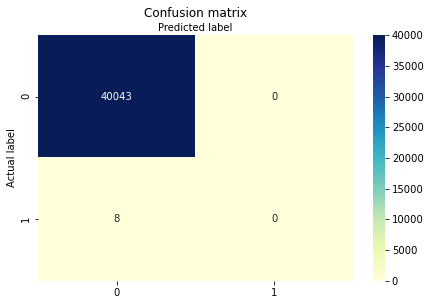

In [44]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_log)
#cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
features = ['Multiplication', 'FieldType', 'Temperature', 'StadiumType', 'PlayerDay','PlayType_c','Position_c' ]
X = m_inju_play_agg[features]
y = m_inju_play_agg['Injury']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

clf = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
clf.score(X_test, y_test)

0.999800254675289

Text(0.5, 257.44, 'Predicted label')

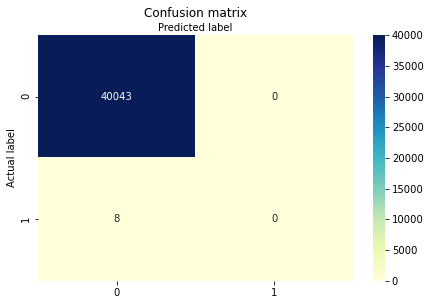

In [47]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
importances = clf.feature_importances_

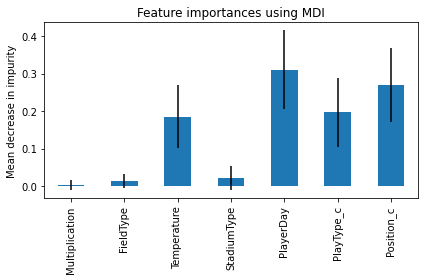

In [49]:
forest_importances = pd.Series(importances, index=features)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The most impactful variable in this subset seems to be 'PlayerDay' which seems to be the particular time of season. 